In [1]:
# helper.py
import heapq
import numpy as np
from collections import deque
from typing import List, Tuple, Dict, Union
from multiprocessing import Array

PLAYER_TIME = Array('f', [0, 0])
HEXAGON_COORDS = {}
CLICK_EVENT = [None]

def is_valid(x, y, dims):
    '''
    Returns whether the coordinates are valid or not
    '''
    return 0 <= x < dims and 0 <= y < dims

def fetch_remaining_time(timer, player_num: int) -> float:
    '''
    Returns the remaining time for the player
    '''
    return timer[player_num - 1]

def get_valid_actions(board: np.array, player: int = None) -> List[Tuple[int, int]]:
    '''
    Returns all the valid actions in the provided state `board`
    '''
    valid_moves = np.argwhere(board == 0)
    valid_moves = [tuple(move) for move in valid_moves]
    return valid_moves

def get_vertices_on_edge(edge: int, dim: int) -> List[Tuple[int, int]]:
    '''
    Returns the vertices on an edge of the board
    '''
    if edge == 0:
        return [(i, 0) for i in range(1, dim // 2)]
    if edge == 1:
        return [(0, j) for j in range(1, dim // 2)]
    if edge == 2:
        return [(0, j) for j in range(dim // 2 + 1, dim - 1)]
    if edge == 3:
        return [(i, dim - 1) for i in range(1, dim // 2)]
    if edge == 4:
        return [(i, 3 * (dim // 2) - i) for i in range(dim // 2 + 1, dim - 1)]
    if edge == 5:
        return [(i, i - dim // 2) for i in range(dim // 2 + 1, dim - 1)]
    return []

def get_vetex_at_corner(corner: int, dim: int) -> Tuple[int, int]:
    '''
    Returns the vertex at a corner of the board
    '''
    if corner == 0:
        return 0, 0
    if corner == 1:
        return 0, dim // 2
    if corner == 2:
        return 0, dim - 1
    if corner == 3:
        return dim // 2, dim - 1
    if corner == 4:
        return dim - 1, dim // 2
    if corner == 5:
        return dim // 2, 0
    return -1, -1

def get_edge(vertex: Tuple[int, int], dim: int) -> int:
    '''
    Returns the edge on which the vertex lies
    '''
    i, j = vertex
    if j == 0 and i > 0 and i < dim // 2:
        return 0
    if i == 0 and j > 0 and j < dim // 2:
        return 1
    if i == 0 and j > dim // 2 and j < dim - 1:
        return 2
    if j == dim - 1 and i > 0 and i < dim // 2:
        return 3
    if i > dim // 2 and i < dim - 1 and i + j == 3 * (dim // 2):
        return 4
    if i > dim // 2 and i < dim - 1 and i - j == dim // 2:
        return 5
    return -1

def get_corner(vertex: Tuple[int, int], dim: int) -> int:
    '''
    Returns the corner at which the vertex lies
    '''
    i, j = vertex
    if i == 0 and j == 0:
        return 0
    if i == 0 and j == dim // 2:
        return 1
    if i == 0 and j == dim - 1:
        return 2
    if i == dim // 2 and j == dim - 1:
        return 3
    if i == dim - 1 and j == dim // 2:
        return 4
    if i == dim // 2 and j == 0:
        return 5
    return -1

def get_neighbours(dim: int, vertex: Tuple[int, int]) -> List[Tuple[int, int]]:
    '''
    Returns the neighbours of the vertex on the board
    '''
    i, j = vertex
    siz = dim//2
    neighbours = []
    if i > 0:
        neighbours.append((i - 1, j))
    if i < dim - 1:
        neighbours.append((i + 1, j))
    if j > 0:
        neighbours.append((i, j - 1))
    if j < dim - 1:
        neighbours.append((i, j + 1))
    if i > 0 and j <= siz and j > 0:
        neighbours.append((i - 1, j - 1))
    if i > 0 and j >= siz and j < dim - 1:
        neighbours.append((i - 1, j + 1))
    if j < siz and i < dim - 1:
        neighbours.append((i + 1, j + 1))
    if j > siz and i < dim - 1:
        neighbours.append((i + 1, j - 1))
    return neighbours

def get_all_corners(dim: int) -> List[Tuple[int, int]]:
    '''
    Returns vertices on all the corners of the board
    '''
    return [(0, 0),
            (0, dim // 2),
            (0, dim - 1),
            (dim // 2, dim - 1),
            (dim - 1, dim // 2),
            (dim // 2, 0)]

def get_all_edges(dim: int) -> List[List[Tuple[int, int]]]:
    '''
    Returns vertices on all the edges of the board
    '''
    siz = ((dim+1)//2)
    sides = [
        [(0, i) for i in range(1, siz-1)],
        [(0, i) for i in range(siz, dim-1)],
        [(i, dim-1) for i in range(1, siz-1)],
        [(siz-1+i, dim-1-i) for i in range(1, siz-1)],
        [(siz-1+i, i) for i in range(1, siz-1)],
        [(i, 0) for i in range(1, siz-1)]
    ]
    return sides

def move_coordinates(direction: str, half: int) -> Tuple[int, int]:
    '''
    Returns the coordinates of the move in the given direction
    '''
    if direction == "up":
        return (-1, 0)
    elif direction == "down":
        return (1, 0)
    elif direction == "top-left":
        if half == 0:
            return (-1, -1)
        elif half < 0:
            return (-1, -1)
        elif half > 0:
            return (0, -1)
    elif direction == "top-right":
        if half == 0:
            return (-1, 1)
        elif half < 0:
            return (0, 1)
        elif half > 0:
            return (-1, 1)
    elif direction == "bottom-left":
        if half == 0:
            return (0, -1)
        elif half < 0:
            return (0, -1)
        elif half > 0:
            return (1, -1)
    elif direction == "bottom-right":
        if half == 0:
            return (0, 1)
        elif half < 0:
            return (1, 1)
        elif half > 0:
            return (0, 1)
    return None

def three_forward_moves(direction: str) -> List[str]:
    '''
    Returns the 3 forward moves from the current direction
    '''
    if direction == "up":
        return ["top-left", "up", "top-right"]
    if direction == "down":
        return ["down", "bottom-left", "bottom-right"]
    if direction == "top-left":
        return ["bottom-left", "top-left", "up"]
    if direction == "top-right":
        return ["top-right", "up", "bottom-right"]
    if direction == "bottom-left":
        return ["bottom-left", "down", "top-left"]
    if direction == "bottom-right":
        return ["bottom-right", "down", "top-right"]
    return None

def bfs_reachable(board: np.array, start: Tuple[int, int]):
    '''
    Returns the set of reachable points accessible from start, via direct neighbours
    '''
    dim = board.shape[0]

    queue = deque([start])
    visited = set()
    visited.add(start)

    while queue:
        current = queue.popleft()
        for nx, ny in get_neighbours(dim, current):
            if is_valid(nx, ny, dim) and (nx, ny) not in visited and board[nx, ny]:
                queue.append((nx, ny))
                visited.add((nx, ny))

    return visited

def find_ring(board: np.array, start: Tuple[int, int]) -> List[Tuple[int, int]]:
    '''
    Returns the points forming a ring with the start point
    '''
    dim = board.shape[0]
    siz = dim // 2
    directions = ["up", "top-left", "bottom-left", "down"]

    def dfs(board, vertex, direction, visited, path, ring_length):
        if vertex == start and ring_length >= 5:
            return True

        x, y = vertex
        half = np.sign(y - siz)
        new_directions = three_forward_moves(direction)
        for new_dir in new_directions:
            direction_coors = move_coordinates(new_dir, half)
            nx, ny = x + direction_coors[0], y + direction_coors[1]
            if is_valid(nx, ny, dim) and board[nx, ny] and (nx, ny, new_dir) not in visited:
                visited.add((nx, ny, new_dir))
                if dfs(board, (nx, ny), new_dir, visited, path, ring_length + 1):
                    path.append(vertex)
                    return True
        return False

    visited = set()
    for direction in directions:
        x, y = start
        half = np.sign(y - siz)
        direction_coors = move_coordinates(direction, half)
        nx, ny = x + direction_coors[0], y + direction_coors[1]
        if is_valid(nx, ny, dim) and board[nx, ny] and (nx, ny, direction) not in visited:
            visited.add((nx, ny, direction))
            child_path = [start]
            if dfs(board, (nx, ny), direction, visited, child_path, 0):
                return child_path
    return []

def find_fork(board: np.array, start: Tuple[int, int]) -> List[Tuple[int, int]]:
    '''
    Returns the points forming a fork with the start point
    '''
    dim = board.shape[0]

    def dfs(board, vertex, visited, path, edges, vis_edge_cnt):
        edge = get_edge(vertex, dim)
        if edge != -1:
            if edge not in edges:
                path.append(vertex)
                edges.append(edge)
            if len(edges) - vis_edge_cnt > 1:
                return

        for nx, ny in get_neighbours(dim, vertex):
            if is_valid(nx, ny, dim) and (nx, ny) not in visited and board[nx, ny]:
                visited.add((nx, ny))
                num_edges = len(edges)
                dfs(board, (nx, ny), visited, path, edges, vis_edge_cnt)
                if len(edges) > num_edges:
                    path.append(vertex)
                if len(edges) - vis_edge_cnt > 1:
                    return
        return

    path = [start]
    visited_edges = []
    edge = get_edge(start, dim)
    if edge != -1:
        visited_edges.append(edge)
    visited = set()
    visited.add(start)
    for nx, ny in get_neighbours(dim, start):
        if is_valid(nx, ny, dim) and board[nx, ny]:
            child_path = []
            num_edges = len(visited_edges)
            dfs(board, (nx, ny), visited, child_path, visited_edges, num_edges)
            if len(visited_edges) > num_edges:
                path.extend(child_path)
            if len(visited_edges) > 2:
                return path
    return path

def find_bridge(board: np.array, start: Tuple[int, int]) -> List[Tuple[int, int]]:
    '''
    Returns the points forming a bridge with the start point
    '''
    dim = board.shape[0]

    def dfs(board, vertex, visited, path):
        corner = get_corner(vertex, dim)
        if corner != -1:
            path.append(vertex)
            return corner

        corner = -1
        for nx, ny in get_neighbours(dim, vertex):
            if is_valid(nx, ny, dim) and (nx, ny) not in visited and board[nx, ny]:
                visited.add((nx, ny))
                corner = dfs(board, (nx, ny), visited, path)
                if corner != -1:
                    path.append(vertex)
                    break
        return corner

    path = [start]
    visited_corner = get_corner(start, dim)
    visited = set()
    visited.add(start)
    for nx, ny in get_neighbours(dim, start):
        if is_valid(nx, ny, dim) and board[nx, ny]:
            child_path = []
            visited.add((nx, ny))
            corner = dfs(board, (nx, ny), visited, child_path)
            if corner != -1 and corner != visited_corner:
                path.extend(child_path)
                if visited_corner == -1:
                    visited_corner = corner
                else:
                    return path
    return path

def check_ring(board: np.array, move: Tuple[int, int]) -> bool:
    '''
    Check whether a ring is formed by the move
    '''
    dim = board.shape[0]
    siz = dim // 2
    init_move = move
    directions = ["up", "top-left", "bottom-left", "down"]
    visited = set()

    neighbours = get_neighbours(dim, move)
    neighbours = [board[neighbour] for neighbour in neighbours]
    if neighbours.count(True) < 2:
        return False

    exploration = []
    for direction in directions:
        x, y = move
        half = np.sign(move[1] - siz)
        direction_coors = move_coordinates(direction, half)
        nx, ny = x + direction_coors[0], y + direction_coors[1]
        if 0 <= nx < dim and 0 <= ny < dim and board[nx, ny]:
            exploration.append(((nx, ny), direction))
            visited.add((nx, ny, direction))

    ring_length = 1
    while (len(exploration) != 0):
        new_exp = []
        for to_explore in exploration:
            move, prev_direction = to_explore
            x, y = move
            half = np.sign(y - siz)
            new_directions = three_forward_moves(prev_direction)
            for direction in new_directions:
                direction_coors = move_coordinates(direction, half)
                nx, ny = x + direction_coors[0], y + direction_coors[1]
                if is_valid(nx, ny, dim) and board[nx, ny] and (nx, ny, direction) not in visited:
                    if init_move == (nx, ny) and ring_length >= 5:
                        return True
                    new_exp.append(((nx, ny), direction))
                    visited.add((nx, ny, direction))
        exploration = new_exp
        ring_length += 1
    return False

def check_bridge(board: np.array, move: Tuple[int, int]) -> bool:
    '''
    Check whether a bridge is formed by the move, via direct neighbours
    '''
    visited = bfs_reachable(board, move)
    dim     = board.shape[0]
    corners = set(get_all_corners(dim))

    reachable_corners = len([corner for corner in corners if corner in visited])
    if reachable_corners >= 2:
        return True
    return False

def check_fork(board: np.array, move: Tuple[int, int]) -> bool:
    '''
    Check whether a fork is formed by the move, via direct neighbours
    '''
    visited = bfs_reachable(board, move)
    dim     = board.shape[0]
    sides   = get_all_edges(dim)
    sides   = [set(side) for side in sides]

    reachable_edges = [1 if len(side.intersection(visited)) > 0 else 0 for side in sides]
    if sum(reachable_edges) >= 3:
        return True

    return False

def check_fork_and_bridge(board: np.array, move: Tuple[int, int]) -> Tuple[bool, Union[str, None]]:
    '''
    Check whether a fork or a bridge is formed by the move, via direct neighbours
    '''
    visited = bfs_reachable(board, move)
    dim     = board.shape[0]
    corners = set(get_all_corners(dim))
    sides = get_all_edges(dim)
    sides = [set(side) for side in sides]

    reachable_edges = [1 if len(side.intersection(visited)) > 0 else 0 for side in sides]
    if sum(reachable_edges) >= 3:
        return True, "fork"

    reachable_corners = len([corner for corner in corners if corner in visited])
    if reachable_corners >= 2:
        return True, "bridge"

    return False, None

def check_win(board: np.array, move: Tuple[int, int], player_num: int, path:List[Tuple[int, int]]=None) -> Tuple[bool, Union[str, None]]:
    '''
    Checks if the player has won the game by placing a move at the given position
    '''
    # Convert to boolean mask for the player
    board = (board == player_num)
    if check_ring(board, move):
        if path != None:
            path.clear()
            path.extend(find_ring(board, move))
        return True, "ring"

    win, way = check_fork_and_bridge(board, move)
    if win:
        if way == "fork":
            if path != None:
                path.clear()
                path.extend(find_fork(board, move))
        elif way == "bridge":
            if path != None:
                path.clear()
                path.extend(find_bridge(board, move))
        return True, way
    return False, None

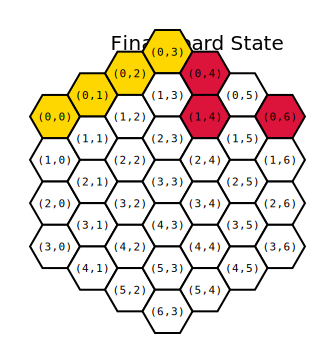

--- Final Game Log ---
Turn 1: Player 1: Minimax AI played (0, 0). (Took 0.13 seconds)
Turn 2: Player 2: Random played (0, 4). (Took 0.00 seconds)
Turn 3: Player 1: Minimax AI played (0, 1). (Took 0.09 seconds)
Turn 4: Player 2: Random played (1, 4). (Took 0.00 seconds)
Turn 5: Player 1: Minimax AI played (0, 2). (Took 0.09 seconds)
Turn 6: Player 2: Random played (0, 6). (Took 0.00 seconds)
Turn 7: Player 1: Minimax AI played (0, 3). (Took 0.00 seconds)

GAME OVER! Player 1: Minimax AI wins with a bridge!


In [2]:
# === MAIN GAME CELL (run after you've executed the helper cell) ===

# --- Import Standard Libraries ---
import numpy as np
import time
import math
import random
from copy import deepcopy
from typing import List, Tuple, Union

# For rendering the SVG image and clearing output in the notebook
from IPython.display import display, SVG, clear_output

print("Setup complete. Running main game (helper functions must already be defined).")

#####################################################################################################################
# CONSTANTS AND SVG VISUALIZATION (unchanged layout logic)
#####################################################################################################################
PLAYER_1 = 1
PLAYER_2 = 2
EMPTY = 0
BLOCKED = 3

def render_board_svg(board, title=""):
    BOARD_SIZE_N = (board.shape[0] + 1) // 2
    hex_radius = 25; padding = 30; sqrt3 = np.sqrt(3)
    def get_hexagon_vertices(r, c):
        offset_x = c * hex_radius * 1.5
        offset_y = (abs(c - BOARD_SIZE_N + 1) + 2 * r) * hex_radius * sqrt3 / 2
        return [
            (hex_radius * 0.5 + offset_x, offset_y), (hex_radius * 1.5 + offset_x, offset_y),
            (hex_radius * 2.0 + offset_x, hex_radius * sqrt3 / 2 + offset_y),
            (hex_radius * 1.5 + offset_x, hex_radius * sqrt3 + offset_y),
            (hex_radius * 0.5 + offset_x, hex_radius * sqrt3 + offset_y),
            (offset_x, hex_radius * sqrt3 / 2 + offset_y),
        ]
    all_vertices = [v for r, c in np.argwhere(board != BLOCKED) for v in get_hexagon_vertices(r, c)]
    if not all_vertices: return
    min_x = min(v[0] for v in all_vertices); max_x = max(v[0] for v in all_vertices)
    min_y = min(v[1] for v in all_vertices); max_y = max(v[1] for v in all_vertices)
    canvas_width = max_x - min_x + 2 * padding; canvas_height = max_y - min_y + 2 * padding
    svg_elements, colors = [], {EMPTY: 'white', PLAYER_1: '#FFD700', PLAYER_2: '#DC143C'}
    svg_elements.append(f'<text x="{canvas_width/2}" y="{padding-10}" font-family="sans-serif" font-size="20" text-anchor="middle" fill="black">{title}</text>')
    for r, c in np.ndindex(board.shape):
        if board[r, c] == BLOCKED: continue
        hex_verts = get_hexagon_vertices(r, c)
        center_x = sum(p[0] for p in hex_verts) / 6; center_y = sum(p[1] for p in hex_verts) / 6
        points_str = " ".join([f"{x},{y}" for x, y in hex_verts])
        svg_elements.append(f'<polygon points="{points_str}" fill="{colors.get(board[r,c], "white")}" stroke="black" stroke-width="2"/>')
        svg_elements.append(f'<text x="{center_x}" y="{center_y}" font-family="monospace" font-size="11" text-anchor="middle" dominant-baseline="central" fill="black">({r},{c})</text>')
    svg_content = "".join(svg_elements)
    display(SVG(f'<svg width="{canvas_width}" height="{canvas_height}" xmlns="http://www.w3.org/2000/svg"><g transform="translate({padding-min_x},{padding-min_y})">{svg_content}</g></svg>'))

#####################################################################################################################
# PLAYER CLASSES (call helper functions directly, helper must be present in kernel)
#####################################################################################################################
class MinimaxAIPlayer:
    def __init__(self, player_number: int, size_n: int, depth=2):
        self.player_number = player_number
        self.opponent_number = PLAYER_2 if player_number == PLAYER_1 else PLAYER_1
        self.size_n = size_n
        self.depth = depth
        self.player_string = f'Player {player_number}: Minimax AI'

    def get_move(self, board: np.array) -> Tuple[int, int]:
        _, best_move = self.minimax(board, self.depth, -math.inf, math.inf, True)
        return best_move

    def minimax(self, board, depth, alpha, beta, maximizing_player):
        valid_moves = get_valid_actions(board)  # helper function (from first cell)
        if depth == 0 or not valid_moves:
            return self.evaluate_board(board), None
        current_player = self.player_number if maximizing_player else self.opponent_number
        best_move = random.choice(valid_moves) if valid_moves else None

        if maximizing_player:
            max_eval = -math.inf
            for move in valid_moves:
                temp_board = deepcopy(board)
                temp_board[move] = current_player
                if check_win(temp_board, move, current_player)[0]:
                    return 10000, move
                evaluation, _ = self.minimax(temp_board, depth - 1, alpha, beta, False)
                if evaluation > max_eval:
                    max_eval, best_move = evaluation, move
                alpha = max(alpha, evaluation)
                if beta <= alpha:
                    break
            return max_eval, best_move
        else:
            min_eval = math.inf
            for move in valid_moves:
                temp_board = deepcopy(board)
                temp_board[move] = current_player
                if check_win(temp_board, move, current_player)[0]:
                    return -10000, move
                evaluation, _ = self.minimax(temp_board, depth - 1, alpha, beta, True)
                if evaluation < min_eval:
                    min_eval, best_move = evaluation, move
                beta = min(beta, evaluation)
                if beta <= alpha:
                    break
            return min_eval, best_move

    def evaluate_board(self, board):
        # unchanged placeholder
        return 0

class HumanPlayer:
    def __init__(self, player_number):
        self.player_number = player_number
        self.player_string = f'Player {player_number}: Human (You)'

    def get_move(self, board: np.array) -> Tuple[int, int]:
        valid_moves = get_valid_actions(board)
        while True:
            try:
                move_str = input("Your turn! Enter move as 'row,col' (e.g., '3,2'): ")
                row_str, col_str = move_str.replace(" ", "").split(',')
                move = (int(row_str), int(col_str))
                if move in valid_moves:
                    return move
                else:
                    print("--> ERROR: Invalid move. Cell may be occupied or out of bounds. Please try again.")
            except (ValueError, IndexError):
                print("--> ERROR: Invalid format. Please enter your move as 'row,col'.")

class RandomPlayer:
    def __init__(self, player_number):
        self.player_number = player_number
        self.player_string = f'Player {player_number}: Random'

    def get_move(self, board: np.array) -> Tuple[int, int]:
        valid_moves = get_valid_actions(board)
        return random.choice(valid_moves) if valid_moves else None

print("All classes defined and will use helper functions from the first cell.")

### --- Game Setup ---
BOARD_SIZE_N = 4
SEARCH_DEPTH = 3 

# --- IMPORTANT ---
# Update the path to your Kaggle dataset file if necessary
board_file_path = '/kaggle/input/boardsize/size4.txt'

try:
    # --- Player Selection ---
    player2 = None
    while player2 is None:
        choice = input("Choose opponent for the AI: type 'human' or 'random' and press Enter: ").lower().strip()
        if choice == 'human':
            player2 = HumanPlayer(player_number=PLAYER_2)
        elif choice == 'random':
            player2 = RandomPlayer(player_number=PLAYER_2)
        else:
            print("Invalid choice. Please type 'human' or 'random'.")

    # --- Game Initialization ---
    game_board = np.loadtxt(board_file_path, dtype=int)
    ai_player = MinimaxAIPlayer(player_number=PLAYER_1, size_n=BOARD_SIZE_N, depth=SEARCH_DEPTH)
    players = {PLAYER_1: ai_player, PLAYER_2: player2}
    current_player_num = PLAYER_1
    turn_count = 0
    move_log = []

    # --- Game Loop ---
    while True:
        clear_output(wait=True)
        current_player = players[current_player_num]

        render_board_svg(game_board, f"Turn {turn_count + 1}: {current_player.player_string}'s Turn")

        print("--- Game Log ---")
        for log_entry in move_log:
            print(log_entry)

        if not get_valid_actions(game_board):
            clear_output(wait=True); render_board_svg(game_board, "Final Board: DRAW")
            print("\n--- Final Game Log ---"); print("\n".join(move_log))
            print("\n" + "#"*50 + "\nGAME OVER! It's a draw - the board is full.\n" + "#"*50)
            break

        turn_count += 1

        print("\n" + "="*40)
        if current_player.player_string.endswith('(You)'):
             move = current_player.get_move(game_board)
             time_taken = 0 # Time is not tracked for human moves
        else:
            print(f"{current_player.player_string} is thinking...")
            start_time = time.time()
            move = current_player.get_move(game_board)
            end_time = time.time()
            time_taken = end_time - start_time
        print("="*40)

        if move is None: break

        # place the move
        game_board[move] = current_player_num

        log_line = f"Turn {turn_count}: {current_player.player_string} played {move}. (Took {time_taken:.2f} seconds)"
        move_log.append(log_line)

        # helper check_win function (must be defined in first cell)
        is_win, win_type = check_win(game_board, move, current_player_num)
        if is_win:
            clear_output(wait=True); render_board_svg(game_board, "Final Board State")
            print("--- Final Game Log ---"); print("\n".join(move_log))
            print("\n" + "="*50 + f"\nGAME OVER! {current_player.player_string} wins with a {win_type}!\n" + "="*50)
            break

        current_player_num = PLAYER_2 if current_player_num == PLAYER_1 else PLAYER_1

except FileNotFoundError:
    print(f"FATAL ERROR: The board file could not be found at '{board_file_path}'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

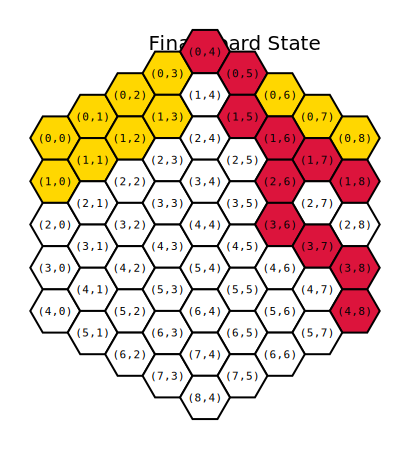

--- Final Game Log ---
Turn 1: Player 1: Minimax AI played (0, 0). (Took 0.38 seconds)
Turn 2: Player 2: Human (You) played (0, 4). (Took 0.00 seconds)
Turn 3: Player 1: Minimax AI played (0, 1). (Took 0.32 seconds)
Turn 4: Player 2: Human (You) played (0, 5). (Took 0.00 seconds)
Turn 5: Player 1: Minimax AI played (0, 2). (Took 0.48 seconds)
Turn 6: Player 2: Human (You) played (1, 5). (Took 0.00 seconds)
Turn 7: Player 1: Minimax AI played (0, 3). (Took 0.30 seconds)
Turn 8: Player 2: Human (You) played (1, 6). (Took 0.00 seconds)
Turn 9: Player 1: Minimax AI played (0, 6). (Took 0.34 seconds)
Turn 10: Player 2: Human (You) played (1, 7). (Took 0.00 seconds)
Turn 11: Player 1: Minimax AI played (0, 8). (Took 0.29 seconds)
Turn 12: Player 2: Human (You) played (1, 8). (Took 0.00 seconds)
Turn 13: Player 1: Minimax AI played (0, 7). (Took 0.39 seconds)
Turn 14: Player 2: Human (You) played (2, 6). (Took 0.00 seconds)
Turn 15: Player 1: Minimax AI played (1, 0). (Took 0.25 seconds)
Turn

In [3]:
### --- Game Setup ---
BOARD_SIZE_N = 5
SEARCH_DEPTH = 3 

# --- IMPORTANT ---
# Update the path to your Kaggle dataset file if necessary
board_file_path = '/kaggle/input/boardsize/size5.txt'

try:
    # --- Player Selection ---
    player2 = None
    while player2 is None:
        choice = input("Choose opponent for the AI: type 'human' or 'random' and press Enter: ").lower().strip()
        if choice == 'human':
            player2 = HumanPlayer(player_number=PLAYER_2)
        elif choice == 'random':
            player2 = RandomPlayer(player_number=PLAYER_2)
        else:
            print("Invalid choice. Please type 'human' or 'random'.")

    # --- Game Initialization ---
    game_board = np.loadtxt(board_file_path, dtype=int)
    ai_player = MinimaxAIPlayer(player_number=PLAYER_1, size_n=BOARD_SIZE_N, depth=SEARCH_DEPTH)
    players = {PLAYER_1: ai_player, PLAYER_2: player2}
    current_player_num = PLAYER_1
    turn_count = 0
    move_log = []

    # --- Game Loop ---
    while True:
        clear_output(wait=True)
        current_player = players[current_player_num]

        render_board_svg(game_board, f"Turn {turn_count + 1}: {current_player.player_string}'s Turn")

        print("--- Game Log ---")
        for log_entry in move_log:
            print(log_entry)

        if not get_valid_actions(game_board):
            clear_output(wait=True); render_board_svg(game_board, "Final Board: DRAW")
            print("\n--- Final Game Log ---"); print("\n".join(move_log))
            print("\n" + "#"*50 + "\nGAME OVER! It's a draw - the board is full.\n" + "#"*50)
            break

        turn_count += 1

        print("\n" + "="*40)
        if current_player.player_string.endswith('(You)'):
             move = current_player.get_move(game_board)
             time_taken = 0 # Time is not tracked for human moves
        else:
            print(f"{current_player.player_string} is thinking...")
            start_time = time.time()
            move = current_player.get_move(game_board)
            end_time = time.time()
            time_taken = end_time - start_time
        print("="*40)

        if move is None: break

        # place the move
        game_board[move] = current_player_num

        log_line = f"Turn {turn_count}: {current_player.player_string} played {move}. (Took {time_taken:.2f} seconds)"
        move_log.append(log_line)

        # helper check_win function (must be defined in first cell)
        is_win, win_type = check_win(game_board, move, current_player_num)
        if is_win:
            clear_output(wait=True); render_board_svg(game_board, "Final Board State")
            print("--- Final Game Log ---"); print("\n".join(move_log))
            print("\n" + "="*50 + f"\nGAME OVER! {current_player.player_string} wins with a {win_type}!\n" + "="*50)
            break

        current_player_num = PLAYER_2 if current_player_num == PLAYER_1 else PLAYER_1

except FileNotFoundError:
    print(f"FATAL ERROR: The board file could not be found at '{board_file_path}'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")